## Initialize notebook

In [135]:
import pandas as pd
import numpy as np
from time import time
from operator import itemgetter
from scipy.stats import randint, truncnorm, uniform

from sklearn import metrics, cross_validation
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from ensemble import EnsembleClassifier

import matplotlib.pyplot as plt
import matplotlib
import seaborn
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 1.7 * matplotlib.rcParams['savefig.dpi']

## Load training data

In [73]:
# load X training data
X_train = np.array(pd.read_csv('X_train.csv', header=None))
# convert any NaNs to 0
X_train = np.nan_to_num(X_train)

# load Y training data
Y_train = np.array(pd.read_csv('Y_train.csv', header=None))
# re-shape array
Y_train = np.reshape(Y_train, (np.shape(Y_train)[0],))
# encode labels
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)

print 'X_train shape: %i x %i' % (np.shape(X_train)[0], np.shape(X_train)[1])
print 'Y_train length: %i' % len(Y_train)

X_train shape: 108 x 34
Y_train length: 108


## Grid search

In [68]:
# Utility function to report best scores
def grid_search_report(grid_scores, n_top=3):
  top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
  for i, score in enumerate(top_scores):
    print('Model with rank: {0}'.format(i + 1))
    print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(
          score.mean_validation_score,
          np.std(score.cv_validation_scores)))
    print('Parameters: {0}'.format(score.parameters))
    print('')

In [111]:
n_iter_search = 100

print 'ExtraTreesClassifier'
cv = cross_validation.ShuffleSplit(len(Y_train), n_iter=5, test_size=0.2, random_state=42)
clf = ExtraTreesClassifier(n_jobs=4, random_state=42)
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10),
              'criterion': ['entropy', 'gini']}

# run randomized search
random_search_xt = RandomizedSearchCV(clf, param_distributions=param_dist,
                                      n_iter=n_iter_search, scoring='accuracy',
                                      n_jobs=4, cv=cv)

start = time()
random_search_xt.fit(X_train, Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_xt.grid_scores_)

ExtraTreesClassifier
RandomizedSearchCV took 175.66 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.845 (std: 0.062)
Parameters: {'min_samples_split': 6, 'n_estimators': 922, 'criterion': 'gini', 'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: 0.845 (std: 0.046)
Parameters: {'min_samples_split': 2, 'n_estimators': 227, 'criterion': 'gini', 'min_samples_leaf': 1}

Model with rank: 3
Mean validation score: 0.845 (std: 0.046)
Parameters: {'min_samples_split': 5, 'n_estimators': 473, 'criterion': 'gini', 'min_samples_leaf': 1}



In [114]:
n_iter_search = 100

print 'GradientBoostingClassifier'
cv = cross_validation.ShuffleSplit(len(Y_train), n_iter=5, test_size=0.2, random_state=42)
clf = GradientBoostingClassifier(random_state=42)
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'max_depth': randint(3, 11),
              'learning_rate': uniform(0.001, 0.3),
              'subsample': uniform(0.001, 0.99),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10)}

# run randomized search
random_search_gb = RandomizedSearchCV(clf, param_distributions=param_dist,
                                      n_iter=n_iter_search, scoring='accuracy',
                                      n_jobs=4, cv=cv)

start = time()
random_search_gb.fit(X_train, Y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_xgb.grid_scores_)

GradientBoostingClassifier
RandomizedSearchCV took 558.68 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.773 (std: 0.029)
Parameters: {'learning_rate': 0.06549212224025243, 'min_samples_leaf': 8, 'n_estimators': 160, 'subsample': 0.40020170113237086, 'min_samples_split': 2, 'max_depth': 4}

Model with rank: 2
Mean validation score: 0.773 (std: 0.057)
Parameters: {'learning_rate': 0.07630549024060841, 'min_samples_leaf': 9, 'n_estimators': 453, 'subsample': 0.9291185487719408, 'min_samples_split': 6, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.727 (std: 0.041)
Parameters: {'learning_rate': 0.017056566901770563, 'min_samples_leaf': 6, 'n_estimators': 482, 'subsample': 0.7841131242280222, 'min_samples_split': 8, 'max_depth': 3}



## Cross-validate (best single models)

In [95]:
def compute_error(clf, X, y, n_iter=20):
  cv = cross_validation.ShuffleSplit(len(y), n_iter=n_iter, test_size=0.2, random_state=42)
  return cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='accuracy').mean()

In [120]:
top_scores = sorted(random_search_xt.grid_scores_, key=itemgetter(1), reverse=True)
clf = ExtraTreesClassifier(n_jobs=4, random_state=42, **top_scores[0].parameters)

print 'Best ExtraTreesClassifier single model score:'
print compute_error(clf, X_train, Y_train, n_iter=5)

Best ExtraTreesClassifier single model score:
0.845454545455


In [121]:
top_scores = sorted(random_search_gb.grid_scores_, key=itemgetter(1), reverse=True)
clf = GradientBoostingClassifier(random_state=42, **top_scores[0].parameters)

print 'Best GradientBoostinfClassifier single model score:'
print compute_error(clf, X_train, Y_train, n_iter=5)

Best GradientBoostinfClassifier single model score:
0.8


## Create ensemble model and CV

In [125]:
top_scores = sorted(random_search_xt.grid_scores_, key=itemgetter(1), reverse=True)
clfs_xt = [ExtraTreesClassifier(n_jobs=4, random_state=42, **top_scores[ii].parameters) 
           for ii in range(3)]

# top_scores = sorted(random_search_gb.grid_scores_, key=itemgetter(1), reverse=True)
# clfs_gb = [GradientBoostingClassifier(random_state=42, **top_scores[ii].parameters) 
#            for ii in range(3)]

# clfs = clfs_xt + clfs_gb
clfs = clfs_xt

In [126]:
eclf = EnsembleClassifier(clfs=clfs, voting='hard')

print 'Ensemble classifier score:'
compute_error(eclf, X_train, Y_train, n_iter=5)

Ensemble classifier score:


0.84545454545454546

## Feature importance

In [130]:
top_scores = sorted(random_search_xt.grid_scores_, key=itemgetter(1), reverse=True)
clf_xt = ExtraTreesClassifier(n_jobs=4, random_state=42, **top_scores[0].parameters)

top_scores = sorted(random_search_gb.grid_scores_, key=itemgetter(1), reverse=True)
clf_gb = GradientBoostingClassifier(random_state=42, **top_scores[0].parameters)

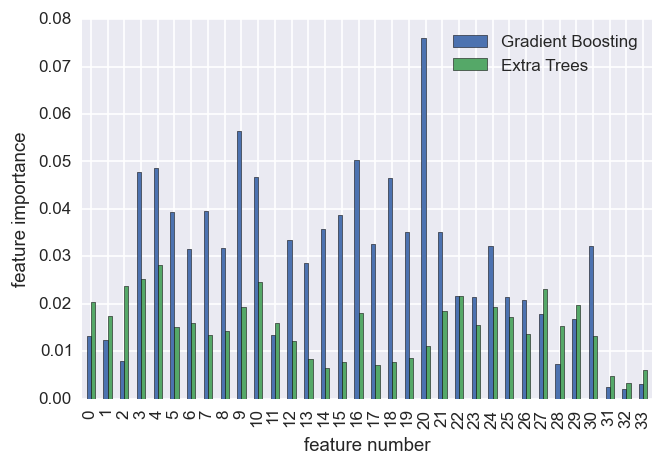

In [136]:
pd.DataFrame([
    clf_xt.fit(X_train, Y_train).feature_importances_,
    clf_gb.fit(X_train, Y_train).feature_importances_
], index=['Gradient Boosting', 'Extra Trees']).T.plot(kind='bar').legend(loc='upper right')
plt.xlabel('feature number')
plt.ylabel('feature importance')